In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
sparcfire_samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
sparcfire = Table.read('../fits/sparcfire/pitch_angles.fits')

ok_P = sparcfire['P'] > 0

spiral_sample = np.all([sparcfire_samples['in_sparcfire'],sparcfire_samples['axial_ok'],
                        sparcfire_samples['in_mass_limit'],sparcfire_samples['in_spiral'],
                        ok_P],axis=0)

print('{} spiral galaxies in total!'.format(spiral_sample.sum()))

2779 spiral galaxies in total!


In [3]:
# Load the individual arc metadata if needed:
L_meta = np.load('../fits/sparcfire/np_metadata/L.npy')
N_meta = np.load('../fits/sparcfire/np_metadata/N_wtd_avg_start.npy')
P_meta = np.load('../fits/sparcfire/np_metadata/P.npy')

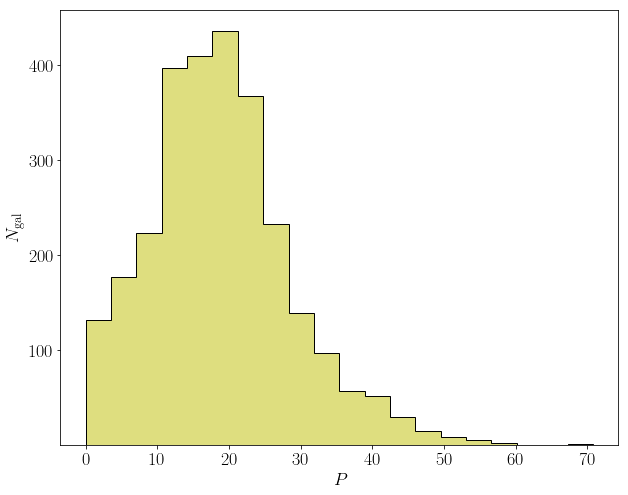

In [4]:
_ = plt.hist(sparcfire['P'][spiral_sample],bins=20,
             color='y',alpha=0.5)
_ = plt.hist(sparcfire['P'][spiral_sample],bins=20,
             histtype='step',color='k',lw=1)
_ = plt.xlabel('$P$')
_ = plt.ylabel('$N_\mathrm{gal}$')

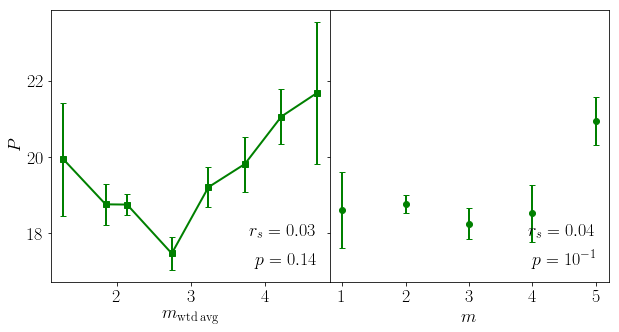

In [5]:
# First basic plot: how does P vary with m?
from xy_plots import x_vs_y

fig, axarr = plt.subplots(1,2,figsize=(10,5),
                          sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

ax = axarr[0]
ax.set_xlabel('$m_\mathrm{wtd \, avg}$')
ax.set_ylabel('$P$')
x = sparcfire['m_wtd_avg'][spiral_sample]
y = sparcfire['P'][spiral_sample]
xy = x_vs_y(x,y)
_ = xy.continuous_vs_continuous_binned(ax,bins=8,
                                       color='g',lw=2,marker='s',capsize=3)
xy.show_spearmanr(ax,location='lower right')

ax = axarr[1]
ax.set_xlabel('$m$')
x = sparcfire['m'][spiral_sample]
y = sparcfire['P'][spiral_sample]
xy = x_vs_y(x,y)
_ = xy.discrete_vs_continuous_binned(ax,color='g',lw=2,fmt='o',capsize=3)
xy.show_spearmanr(ax,location='lower right')

#fig.savefig('figures/m_vs_P.pdf')

In [6]:
def histogram_stack(x,x_ref,m_mask,bins=None,percentiles=True):
    
    colors = ['orange','r','m','g','b']
    mlabels = ['1','2','3','4','5+']
    
    fig, axarr = plt.subplots(5,1,figsize=(10,15),
                              sharex=True,sharey=True)
    fig.subplots_adjust(hspace=0,wspace=0)
    for m in range(5):
        in_m = m_mask == m+1
        plt.sca(axarr[m])
        label_string = '$m={} \, (N_\mathrm{{gal}}={})$'.format(mlabels[m],
                                                               in_m.sum())
        plt.hist(x_ref,bins=bins,normed=True,
                 histtype='stepfilled',color='k',alpha=0.3)
        plt.hist(x_ref,bins=bins,normed=True,
                 histtype='step',color='k',lw=1)
        plt.hist(x[in_m],bins=bins,normed=True,
                 histtype='step',color=colors[m],lw=3)
        plt.text(0.975,0.925,label_string,
                 transform=axarr[m].transAxes,ha='right',va='top')
        plt.ylabel('normalised \n density')
        if percentiles is True:
            for percentile in (16,50,84):
                plt.axvline(np.percentile(x[in_m],percentile),
                            color=colors[m],lw=2,linestyle='dashed')
    return fig, axarr

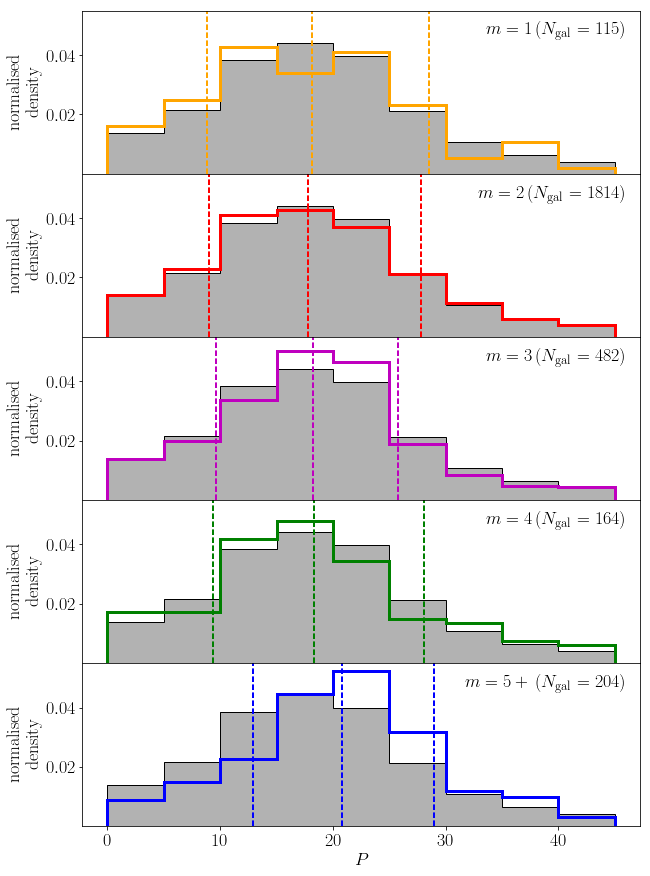

In [7]:
fig, axarr = histogram_stack(y,y,sparcfire['m'][spiral_sample],bins=np.linspace(0,45,10))

axarr[-1].set_xlabel('$P$')

#fig.savefig('figures/Pm_histograms.pdf')

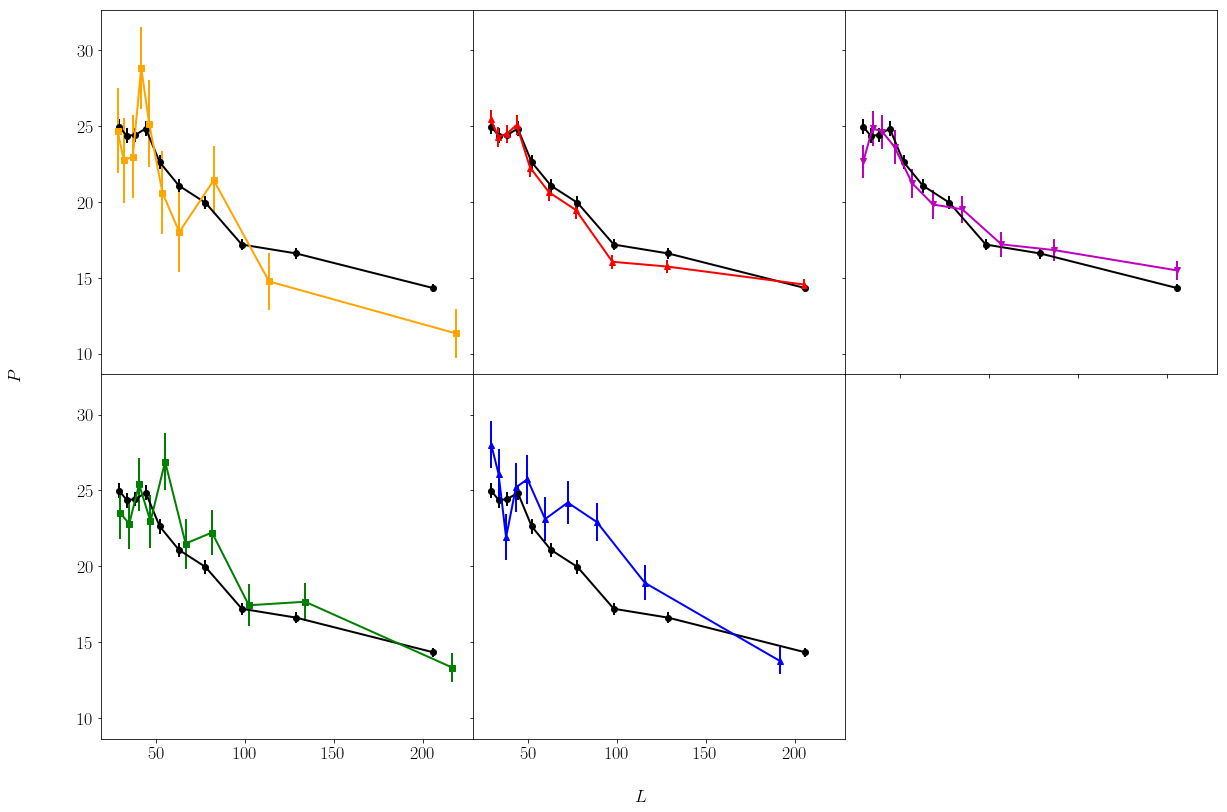

In [11]:
# Now for the individual arcs:
colors = ['orange','r','m','g','b']
markers = 's^vs^vs^v'

fig, axarr = plt.subplots(2,3,figsize=(20,13.4),
                          sharex=True,sharey=True)
fig.subplots_adjust(wspace=0,hspace=0)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

L_arcs = L_meta[spiral_sample]
P_arcs = P_meta[spiral_sample]
P_arcs_absolute = np.absolute(P_arcs)
N_rows, N_columns = np.shape(L_arcs)

m_wtd_avg_array = np.repeat(sparcfire['m_wtd_avg'][spiral_sample],N_columns).reshape(N_rows,N_columns)
m_absolute_array = np.repeat(sparcfire['m'][spiral_sample],N_columns).reshape(N_rows,N_columns)

arcs_ok = L_arcs > 0

x_reference = L_arcs[arcs_ok].ravel()
y_reference = P_arcs_absolute[arcs_ok].ravel()
xy_reference = x_vs_y(x_reference,y_reference)

for m in range(5):
    ax = axarr[m]
    plt.sca(ax)
    xy_reference.continuous_vs_continuous_binned(ax,color='k',lw=2,marker='o',equal_N=True)
    x = L_arcs[(arcs_ok) & (m_absolute_array == m+1)].ravel()
    y = P_arcs_absolute[(arcs_ok) & (m_absolute_array == m+1)].ravel()
    xy = x_vs_y(x,y)
    xy.continuous_vs_continuous_binned(ax,color=colors[m],lw=2,marker=markers[m],equal_N=True)

#p, _ = curve_fit(exp,x,y)

fig.text(0.5, 0.06, '$L$', ha='center')
fig.text(0.06, 0.5, '$P$', va='center', rotation='vertical')

#fig.savefig('figures/L_vs_Pm.pdf')